# Machine Learning Based Traffic Analysis of Video Conferencing Services in rural communities - Main

# 📚 | Import Libraries

In [1]:
import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

## Library Versions

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


# 💾 | Data Preparation

## Initial Inspection

### The Zoom480pRaw Dataset contains the following QoS metrics :

#### 1. Local time : The timestamp indicating when the data was captured.
#### 2. Download (Rx) bandwidth (bps) : The bandwidth available for downloading data, measured in bits per second (bps).
#### 3. Upload (Tx) bandwidth (bps) : The bandwidth available for uploading data, measured in bits per second (bps).
#### 4. Rx packet loss (percent) : Percentage of packets lost during download.
#### 5. Tx packet loss (percent) : Percentage of packets lost during upload.
#### 6. RTT (ping) (ms : Round Trip Time (RTT) measures the time (in milliseconds) for a signal to travel to the server and back.
#### 7. Rx instant jitter (ms) : Instantaneous jitter during download, measured in millisecond
#### 8. Tx instant jitter (ms) : Instantaneous jitter during upload, measured in milliseconds.
#### 9. Rx RFC3550 jitter (ms) : Jitter measured according to the RFC3550 standard for downloading packets.
#### 10.Tx RFC3550 jitter (ms) : Jitter measured according to the RFC3550 standard for uploading packets
#### 11.Rx packet loss burst length (packets) : The number of consecutive packets lost during download.
#### 12.Tx packet loss burst length (packets) : The number of consecutive packets lost during upload.


#### 13.Download bandwidth &
#### 14.Upload Bandwidth : These columns represent textual descriptions of bandwidth values in a human-readable format, such as 2.08 bps/4.00 bps.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/kaggle/input/zoom480p/zoom480pRaw.csv'  # Update this path based on your Kaggle dataset location
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
display(data.head())

# Display basic information about the dataset
print("\nDataset Info:")
data.info()

# Check for missing values
print("\nMissing Values per Column:")
print(data.isnull().sum())

# Display summary statistics
print("\nSummary Statistics:")
display(data.describe())


First few rows of the dataset:


,Local time,Download (Rx) bandwidth (bps),Download bandwidth,Rx packet loss (percent),Upload (Tx) bandwidth (bps),Upload bandwidth,Tx packet loss (percent),RTT (ping) (ms),Rx packet loss burst length (packets),Tx packet loss burst length (packets),Rx instant jitter (ms),Tx instant jitter (ms),Rx RFC3550 jitter (ms),Tx RFC3550 jitter (ms)
0,22-11-2023 17:29,2180459.5,2.08Mbps/4.00Mbps,0.391257,2095309.0,2.00Mbps/2.00Mbps,0.015329,76.0,1.999964,2.000007,13.937400,41.205400,7.645997,12.341899
1,22-11-2023 17:29,2248265.8,2.14Mbps/4.00Mbps,0.000008,2091075.0,1.99Mbps/2.00Mbps,0.017393,49.0,2.004499,2.000006,13.645300,42.226900,7.118157,11.712419
2,22-11-2023 17:29,2260864.2,2.16Mbps/4.00Mbps,0.000010,2091325.8,1.99Mbps/2.00Mbps,0.022528,49.0,2.004499,2.000006,11.302199,35.522100,7.314697,10.271344
3,22-11-2023 17:29,2241506.5,2.14Mbps/4.00Mbps,0.000013,2093249.1,2.00Mbps/2.00Mbps,0.028613,61.0,2.004499,2.000007,15.900100,43.328598,7.379264,11.401575
4,22-11-2023 17:29,2267823.2,2.16Mbps/4.00Mbps,0.000016,2096676.4,2.00Mbps/2.00Mbps,0.032748,48.0,2.004499,2.000007,13.352600,44.489800,7.549689,12.029810



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Local time                             729 non-null    object 
 1   Download (Rx) bandwidth (bps)          729 non-null    float64
 2   Download bandwidth                     729 non-null    object 
 3   Rx packet loss (percent)               729 non-null    float64
 4   Upload (Tx) bandwidth (bps)            729 non-null    float64
 5   Upload bandwidth                       729 non-null    object 
 6   Tx packet loss (percent)               729 non-null    float64
 7   RTT (ping) (ms)                        729 non-null    float64
 8   Rx packet loss burst length (packets)  729 non-null    float64
 9   Tx packet loss burst length (packets)  729 non-null    float64
 10  Rx instant jitter (ms)                 729 non-null    floa

,Download (Rx) bandwidth (bps),Rx packet loss (percent),Upload (Tx) bandwidth (bps),Tx packet loss (percent),RTT (ping) (ms),Rx packet loss burst length (packets),Tx packet loss burst length (packets),Rx instant jitter (ms),Tx instant jitter (ms),Rx RFC3550 jitter (ms),Tx RFC3550 jitter (ms)
count,7.290000e+02,729.000000,7.290000e+02,7.290000e+02,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,2.141659e+06,0.365736,2.090474e+06,5.370571e-03,60.315989,1.420049,0.601510,17.623750,45.263511,7.360208,11.536054
std,1.976289e+05,0.654023,1.538648e+04,3.084224e-02,17.524060,0.550051,0.979640,11.635208,29.746005,1.825422,3.023425
min,8.913121e+05,0.000000,1.846313e+06,0.000000e+00,36.000000,0.000000,0.000000,0.652100,0.500000,3.646425,5.792518
25%,2.049401e+06,0.000035,2.090931e+06,0.000000e+00,50.000000,1.076822,0.000000,13.376300,29.455100,6.478156,9.351850
50%,2.183379e+06,0.014022,2.094055e+06,0.000000e+00,57.000000,1.504040,0.000000,15.763100,36.600098,7.340136,10.855251
75%,2.269906e+06,0.452934,2.096313e+06,2.330000e-10,66.000000,1.803219,0.500000,18.798600,51.554800,7.964654,12.675699
max,2.456452e+06,3.727192,2.097152e+06,4.254852e-01,195.620390,3.000000,2.500014,126.406494,409.229000,20.897910,36.682903


## Redundancy Checking between Rx and Tx metrics.



Correlation Matrix for Rx and Tx Metrics:
                          Rx packet loss (percent)  Tx packet loss (percent)  \
Rx packet loss (percent)                  1.000000                 -0.095837   
Tx packet loss (percent)                 -0.095837                  1.000000   
Rx instant jitter (ms)                    0.066013                  0.004015   
Tx instant jitter (ms)                   -0.145542                 -0.003814   

                          Rx instant jitter (ms)  Tx instant jitter (ms)  
Rx packet loss (percent)                0.066013               -0.145542  
Tx packet loss (percent)                0.004015               -0.003814  
Rx instant jitter (ms)                  1.000000                0.268407  
Tx instant jitter (ms)                  0.268407                1.000000  


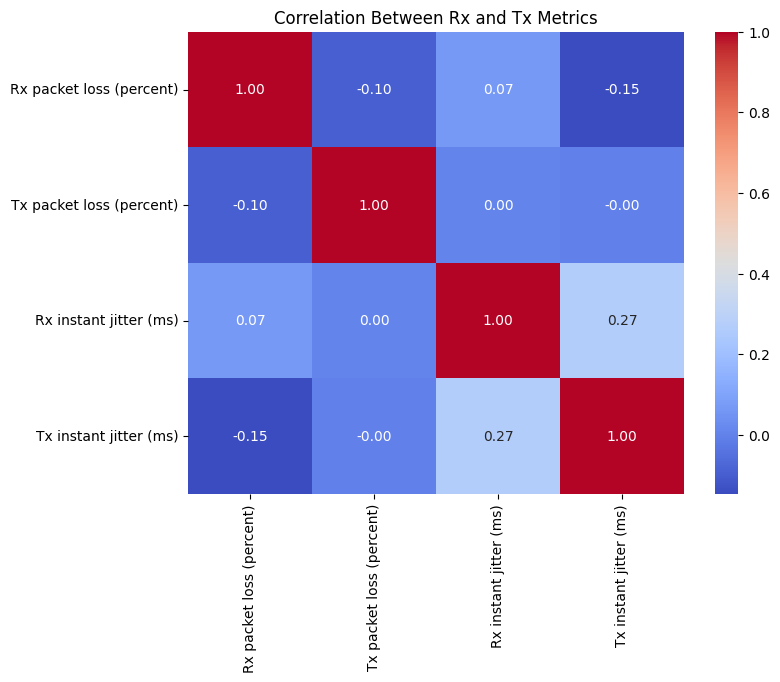

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations between Rx and Tx metrics
rx_tx_correlations = data[[
    'Rx packet loss (percent)', 'Tx packet loss (percent)',
    'Rx instant jitter (ms)', 'Tx instant jitter (ms)'
]].corr()

# Display the correlation matrix
print("\nCorrelation Matrix for Rx and Tx Metrics:")
print(rx_tx_correlations)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rx_tx_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Rx and Tx Metrics')
plt.show()


### The low correlation values indicate that Rx and Tx metrics do not show significant redundancy. This suggests that both metrics capture different aspects of the network's QoS and should be retained. There is no strong redundancy between Rx and Tx jitter or packet loss. Hence, both sets of metrics can provide unique value for analyzing the dataset.

## Redundancy checking between RFC3550 jitter (ms) & Instant Jitter (ms)

Correlation Matrix for Jitter Metrics:
                        Rx instant jitter (ms)  Tx instant jitter (ms)  \
Rx instant jitter (ms)                1.000000                0.268407   
Tx instant jitter (ms)                0.268407                1.000000   
Rx RFC3550 jitter (ms)                0.674260                0.351089   
Tx RFC3550 jitter (ms)                0.212403                0.884349   

                        Rx RFC3550 jitter (ms)  Tx RFC3550 jitter (ms)  
Rx instant jitter (ms)                0.674260                0.212403  
Tx instant jitter (ms)                0.351089                0.884349  
Rx RFC3550 jitter (ms)                1.000000                0.368488  
Tx RFC3550 jitter (ms)                0.368488                1.000000  


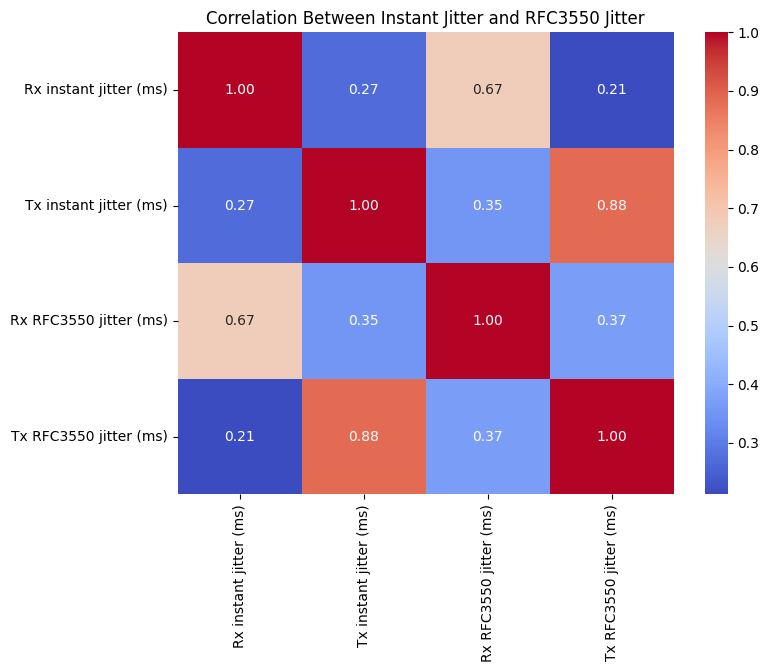

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select jitter columns for correlation analysis
jitter_columns = [
    'Rx instant jitter (ms)', 'Tx instant jitter (ms)', 
    'Rx RFC3550 jitter (ms)', 'Tx RFC3550 jitter (ms)'
]

# Calculate correlation matrix
jitter_correlation = data[jitter_columns].corr()

# Display the correlation matrix
print("Correlation Matrix for Jitter Metrics:")
print(jitter_correlation)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(jitter_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Instant Jitter and RFC3550 Jitter")
plt.show()


### We can see high values (e.g., 0.8 or above) between:

### * Rx instant jitter (ms) and Rx RFC3550 jitter (ms).
### * Tx instant jitter (ms) and Tx RFC3550 jitter (ms).

### Since instant jitter is more intuitive and directly reflects real-time conditions, keeping it and dropping RFC3550 jitter simplifies the model without losing much information.

## Cleaning & Extracting Necessary Features

### Column selection retained the most relevant features, reducing unnecessary noise in the dataset.

### Columns Dropped:

### 1. Download bandwidth: Redundant, as Download (Rx) bandwidth (bps) provides the same information in numeric format.
### 2. Upload bandwidth:   Redundant, as Upload (Tx) bandwidth (bps) provides the same information in numeric format.

### 3. Rx RFC3550 jitter (ms)
### 4. Tx RFC3550 jitter (ms) 

### The dataset already includes Rx instant jitter (ms) and Tx instant jitter (ms), which capture jitter values for incoming and outgoing packets.The RFC3550 jitter columns represent a standardized method to compute jitter, but in practice, they are often highly correlated with the "instant jitter" columns.

### 5. Rx packet loss burst length (packets)
### 6. Tx packet loss burst length (packets)

### These columns measure the length of consecutive packets lost during download (Rx) or upload (Tx).
### While they provide detailed insights into packet loss events, their impact is already captured by Rx packet loss (percent) and Tx packet loss (percent): For example, if 5 packets are lost consecutively, it would already contribute to the total packet loss percentage.
### We chose Packet Loss Percent over the Number of Packets Dropped because it is normalized, allowing for easy comparison across datasets and services, regardless of the total packet count. Additionally, it is more directly correlated with QoE and easier for machine learning models to interpret and scale.

In [6]:
# Select necessary numeric columns for analysis
columns_to_keep = [
    "Local time", 
    "Download (Rx) bandwidth (bps)", 
    "Upload (Tx) bandwidth (bps)",
    "Rx packet loss (percent)", 
    "Tx packet loss (percent)", 
    "RTT (ping) (ms)",
    "Rx instant jitter (ms)", 
    "Tx instant jitter (ms)"
]

# Subset the dataset
data = data[columns_to_keep]

# Display the cleaned subset
print("Selected Columns:")
display(data.head())

# Check for any missing or invalid values in the selected columns
print("\nMissing Values After Column Selection:")
print(data.isnull().sum())


Selected Columns:


,Local time,Download (Rx) bandwidth (bps),Upload (Tx) bandwidth (bps),Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms)
0,22-11-2023 17:29,2180459.5,2095309.0,0.391257,0.015329,76.0,13.937400,41.205400
1,22-11-2023 17:29,2248265.8,2091075.0,0.000008,0.017393,49.0,13.645300,42.226900
2,22-11-2023 17:29,2260864.2,2091325.8,0.000010,0.022528,49.0,11.302199,35.522100
3,22-11-2023 17:29,2241506.5,2093249.1,0.000013,0.028613,61.0,15.900100,43.328598
4,22-11-2023 17:29,2267823.2,2096676.4,0.000016,0.032748,48.0,13.352600,44.489800



Missing Values After Column Selection:
Local time                       0
Download (Rx) bandwidth (bps)    0
Upload (Tx) bandwidth (bps)      0
Rx packet loss (percent)         0
Tx packet loss (percent)         0
RTT (ping) (ms)                  0
Rx instant jitter (ms)           0
Tx instant jitter (ms)           0
dtype: int64


## Mean Jitter & Jitter Difference

###  **Mean Jitter**

* ### QoE is often affected by the overall jitter in the network, not just Rx (receive) or Tx (transmit) jitter individually.
* ### Mean Jitter provides a single value summarizing the average network instability, representing the combined impact of incoming and outgoing jitter.

### **Jitter Difference**

* ### When there’s a significant difference between Rx and Tx jitter, it often indicates imbalanced network conditions (e.g., poor uplink but stable downlink).
* ### A large Jitter Difference value helps pinpoint whether the bottleneck is on the upload (Tx) or download (Rx) side of the network.


In [7]:
data['Mean Jitter'] = (data['Rx instant jitter (ms)'] + data['Tx instant jitter (ms)']) / 2

data['Jitter Difference'] = data['Rx instant jitter (ms)'] - data['Tx instant jitter (ms)']


## Unit Consistency

###  Ensures all numeric metrics are in comparable units. bps (bandwidth) was converted to Mbps for easier interpretation.

In [8]:
# Convert bandwidth metrics from bps to Mbps
data['Download (Rx) bandwidth (Mbps)'] = data['Download (Rx) bandwidth (bps)'] / 1e6
data['Upload (Tx) bandwidth (Mbps)'] = data['Upload (Tx) bandwidth (bps)'] / 1e6

# Drop the original bandwidth columns (in bps) to avoid confusion
data.drop(columns=['Download (Rx) bandwidth (bps)', 'Upload (Tx) bandwidth (bps)'], inplace=True)

# Display the updated dataset
print("\nDataset After Unit Conversion:")
display(data.head())



Dataset After Unit Conversion:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps)
0,22-11-2023 17:29,0.391257,0.015329,76.0,13.937400,41.205400,27.571400,-27.268000,2.180459,2.095309
1,22-11-2023 17:29,0.000008,0.017393,49.0,13.645300,42.226900,27.936100,-28.581600,2.248266,2.091075
2,22-11-2023 17:29,0.000010,0.022528,49.0,11.302199,35.522100,23.412150,-24.219901,2.260864,2.091326
3,22-11-2023 17:29,0.000013,0.028613,61.0,15.900100,43.328598,29.614349,-27.428498,2.241506,2.093249
4,22-11-2023 17:29,0.000016,0.032748,48.0,13.352600,44.489800,28.921200,-31.137200,2.267823,2.096676


## Standardizing the Timestamp

### Timestamps in the raw dataset might be in string format, making it difficult to perform time-based calculations or analysis. Standardization converts them to a machine-readable datetime format.

In [9]:
# Convert "Local time" to datetime format
data['Local time'] = pd.to_datetime(data['Local time'], errors='coerce')

# Check for invalid timestamps
print("\nRows with Invalid Timestamps:")
print(data[data['Local time'].isnull()])

# Remove rows with invalid timestamps
data = data.dropna(subset=['Local time'])

# Sort the data by timestamp (if not already sorted)
data = data.sort_values(by='Local time')

# Display the standardized timestamps
print("\nData After Standardizing Timestamps:")
display(data.head())


Rows with Invalid Timestamps:
Empty DataFrame
Columns: [Local time, Rx packet loss (percent), Tx packet loss (percent), RTT (ping) (ms), Rx instant jitter (ms), Tx instant jitter (ms), Mean Jitter, Jitter Difference, Download (Rx) bandwidth (Mbps), Upload (Tx) bandwidth (Mbps)]
Index: []

Data After Standardizing Timestamps:


/tmp/ipykernel_17/1601050059.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Local time'] = pd.to_datetime(data['Local time'], errors='coerce')


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps)
728,2023-11-22 17:15:00,0.000000,0.0,59.00000,18.075400,33.649998,25.862699,-15.574598,1.597503,2.073520
706,2023-11-22 17:15:00,0.057744,0.0,42.00000,14.900800,25.573900,20.237350,-10.673100,1.785374,2.071365
707,2023-11-22 17:15:00,0.000000,0.0,42.00000,15.165999,59.054398,37.110198,-43.888399,1.782008,2.097152
708,2023-11-22 17:15:00,0.000000,0.0,195.62039,62.715897,51.525997,57.120947,11.189900,1.726811,1.990756
709,2023-11-22 17:15:00,0.000000,0.0,115.00000,32.779000,51.525997,42.152499,-18.746997,2.013898,2.074388


## Adding Elapsed Time Feature

### To introduce a temporal dimension, capturing how QoS metrics change over time. Helps identify whether network conditions improve or degrade over time.

In [10]:
# Calculate elapsed time in seconds from the first timestamp
data['Elapsed Time'] = (data['Local time'] - data['Local time'].iloc[0]).dt.total_seconds()

# Display the dataset with the new "Elapsed Time" column
print("\nDataset with Elapsed Time:")
display(data.head(100))


Dataset with Elapsed Time:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
728,2023-11-22 17:15:00,0.000000e+00,0.0,59.00000,18.075400,33.649998,25.862699,-15.574598,1.597503,2.073520,0.0
706,2023-11-22 17:15:00,5.774397e-02,0.0,42.00000,14.900800,25.573900,20.237350,-10.673100,1.785374,2.071365,0.0
707,2023-11-22 17:15:00,0.000000e+00,0.0,42.00000,15.165999,59.054398,37.110198,-43.888399,1.782008,2.097152,0.0
708,2023-11-22 17:15:00,0.000000e+00,0.0,195.62039,62.715897,51.525997,57.120947,11.189900,1.726811,1.990756,0.0
709,2023-11-22 17:15:00,0.000000e+00,0.0,115.00000,32.779000,51.525997,42.152499,-18.746997,2.013898,2.074388,0.0
...,...,...,...,...,...,...,...,...,...,...,...
601,2023-11-22 17:17:00,8.230000e-08,0.0,63.00000,14.017699,26.984499,20.501099,-12.966800,2.383072,2.092579,120.0
594,2023-11-22 17:17:00,0.000000e+00,0.0,46.00000,13.104400,23.762700,18.433550,-10.658300,2.456453,2.094249,120.0
599,2023-11-22 17:17:00,1.372995e+00,0.0,53.00000,22.653000,32.599300,27.626150,-9.946300,2.266962,2.097152,120.0
598,2023-11-22 17:17:00,1.107951e+00,0.0,63.00000,11.134399,22.435299,16.784849,-11.300900,2.337873,2.094947,120.0


## Handling Missing & Invalid Data

In [11]:
# Check for missing values in numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
print("\nMissing Values in Numeric Columns Before Imputation:")
print(data[numeric_columns].isnull().sum())

# Impute missing values with the mean of each column
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Verify missing values are handled
print("\nMissing Values After Imputation:")
print(data[numeric_columns].isnull().sum())



Missing Values in Numeric Columns Before Imputation:
Rx packet loss (percent)          0
Tx packet loss (percent)          0
RTT (ping) (ms)                   0
Rx instant jitter (ms)            0
Tx instant jitter (ms)            0
Mean Jitter                       0
Jitter Difference                 0
Download (Rx) bandwidth (Mbps)    0
Upload (Tx) bandwidth (Mbps)      0
Elapsed Time                      0
dtype: int64

Missing Values After Imputation:
Rx packet loss (percent)          0
Tx packet loss (percent)          0
RTT (ping) (ms)                   0
Rx instant jitter (ms)            0
Tx instant jitter (ms)            0
Mean Jitter                       0
Jitter Difference                 0
Download (Rx) bandwidth (Mbps)    0
Upload (Tx) bandwidth (Mbps)      0
Elapsed Time                      0
dtype: int64


## Outlier Detection & Analysis

### Outlier Detection:


* ### Used z-scores to identify rows with extreme values (absolute z-score > 3) in numeric columns.
* ### Marked these rows as outliers using a binary column (Is Outlier).
* ### Instead of removing outliers, flagged them for separate analysis, as they represent critical rural network conditions.

Number of Outliers Preserved: 70

Summary of Outliers:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
count,70,70.000000,7.000000e+01,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,2023-11-22 17:21:53.142857216,0.971732,3.768765e-02,76.439167,30.567184,66.448514,48.507849,-35.881330,1.941360,2.077026,413.142857
min,2023-11-22 17:15:00,0.000000,0.000000e+00,42.000000,7.316100,3.765300,5.540700,-391.736101,0.891312,1.846313,0.000000
25%,2023-11-22 17:19:00,0.000031,0.000000e+00,54.000000,14.060325,31.347300,24.155575,-40.324024,1.817693,2.084503,240.000000
50%,2023-11-22 17:21:30,0.365787,1.759000e-13,63.000000,17.315200,45.312849,34.116174,-20.629049,1.962608,2.091628,390.000000
75%,2023-11-22 17:26:00,2.245641,2.294508e-03,77.750000,23.503325,91.514521,57.896337,-9.446900,2.217237,2.096104,660.000000
max,2023-11-22 17:29:00,3.727192,4.254852e-01,195.620390,126.406494,409.229000,213.360950,53.370200,2.399272,2.097152,840.000000
std,NaN,1.219064,8.876166e-02,38.999636,30.925376,64.411476,38.992560,64.255389,0.350603,0.041862,257.926755



Summary of Non-Outliers:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time
count,659,659.000000,6.590000e+02,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,2023-11-22 17:22:08.649468928,0.301367,1.937801e-03,58.603360,16.248879,43.013208,29.631043,-26.764329,2.162935,2.091903,428.649469
min,2023-11-22 17:15:00,0.000000,0.000000e+00,36.000000,0.652100,0.500000,1.944200,-108.972600,1.597503,2.045636,0.000000
25%,2023-11-22 17:18:00,0.000035,0.000000e+00,50.000000,13.310849,29.350450,22.602375,-34.659551,2.077518,2.091348,180.000000
50%,2023-11-22 17:21:00,0.011524,0.000000e+00,57.000000,15.605000,36.149498,26.550149,-20.861800,2.193316,2.094111,360.000000
75%,2023-11-22 17:26:00,0.386542,1.570000e-10,64.000000,18.649450,50.251199,33.758800,-12.401600,2.272177,2.096325,660.000000
max,2023-11-22 17:29:00,2.304205,9.084158e-02,106.000000,45.817497,129.796200,82.183200,29.542701,2.456453,2.097152,840.000000
std,NaN,0.523636,1.016629e-02,12.234197,5.456673,22.160277,11.826627,21.959733,0.160002,0.007542,266.109817


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

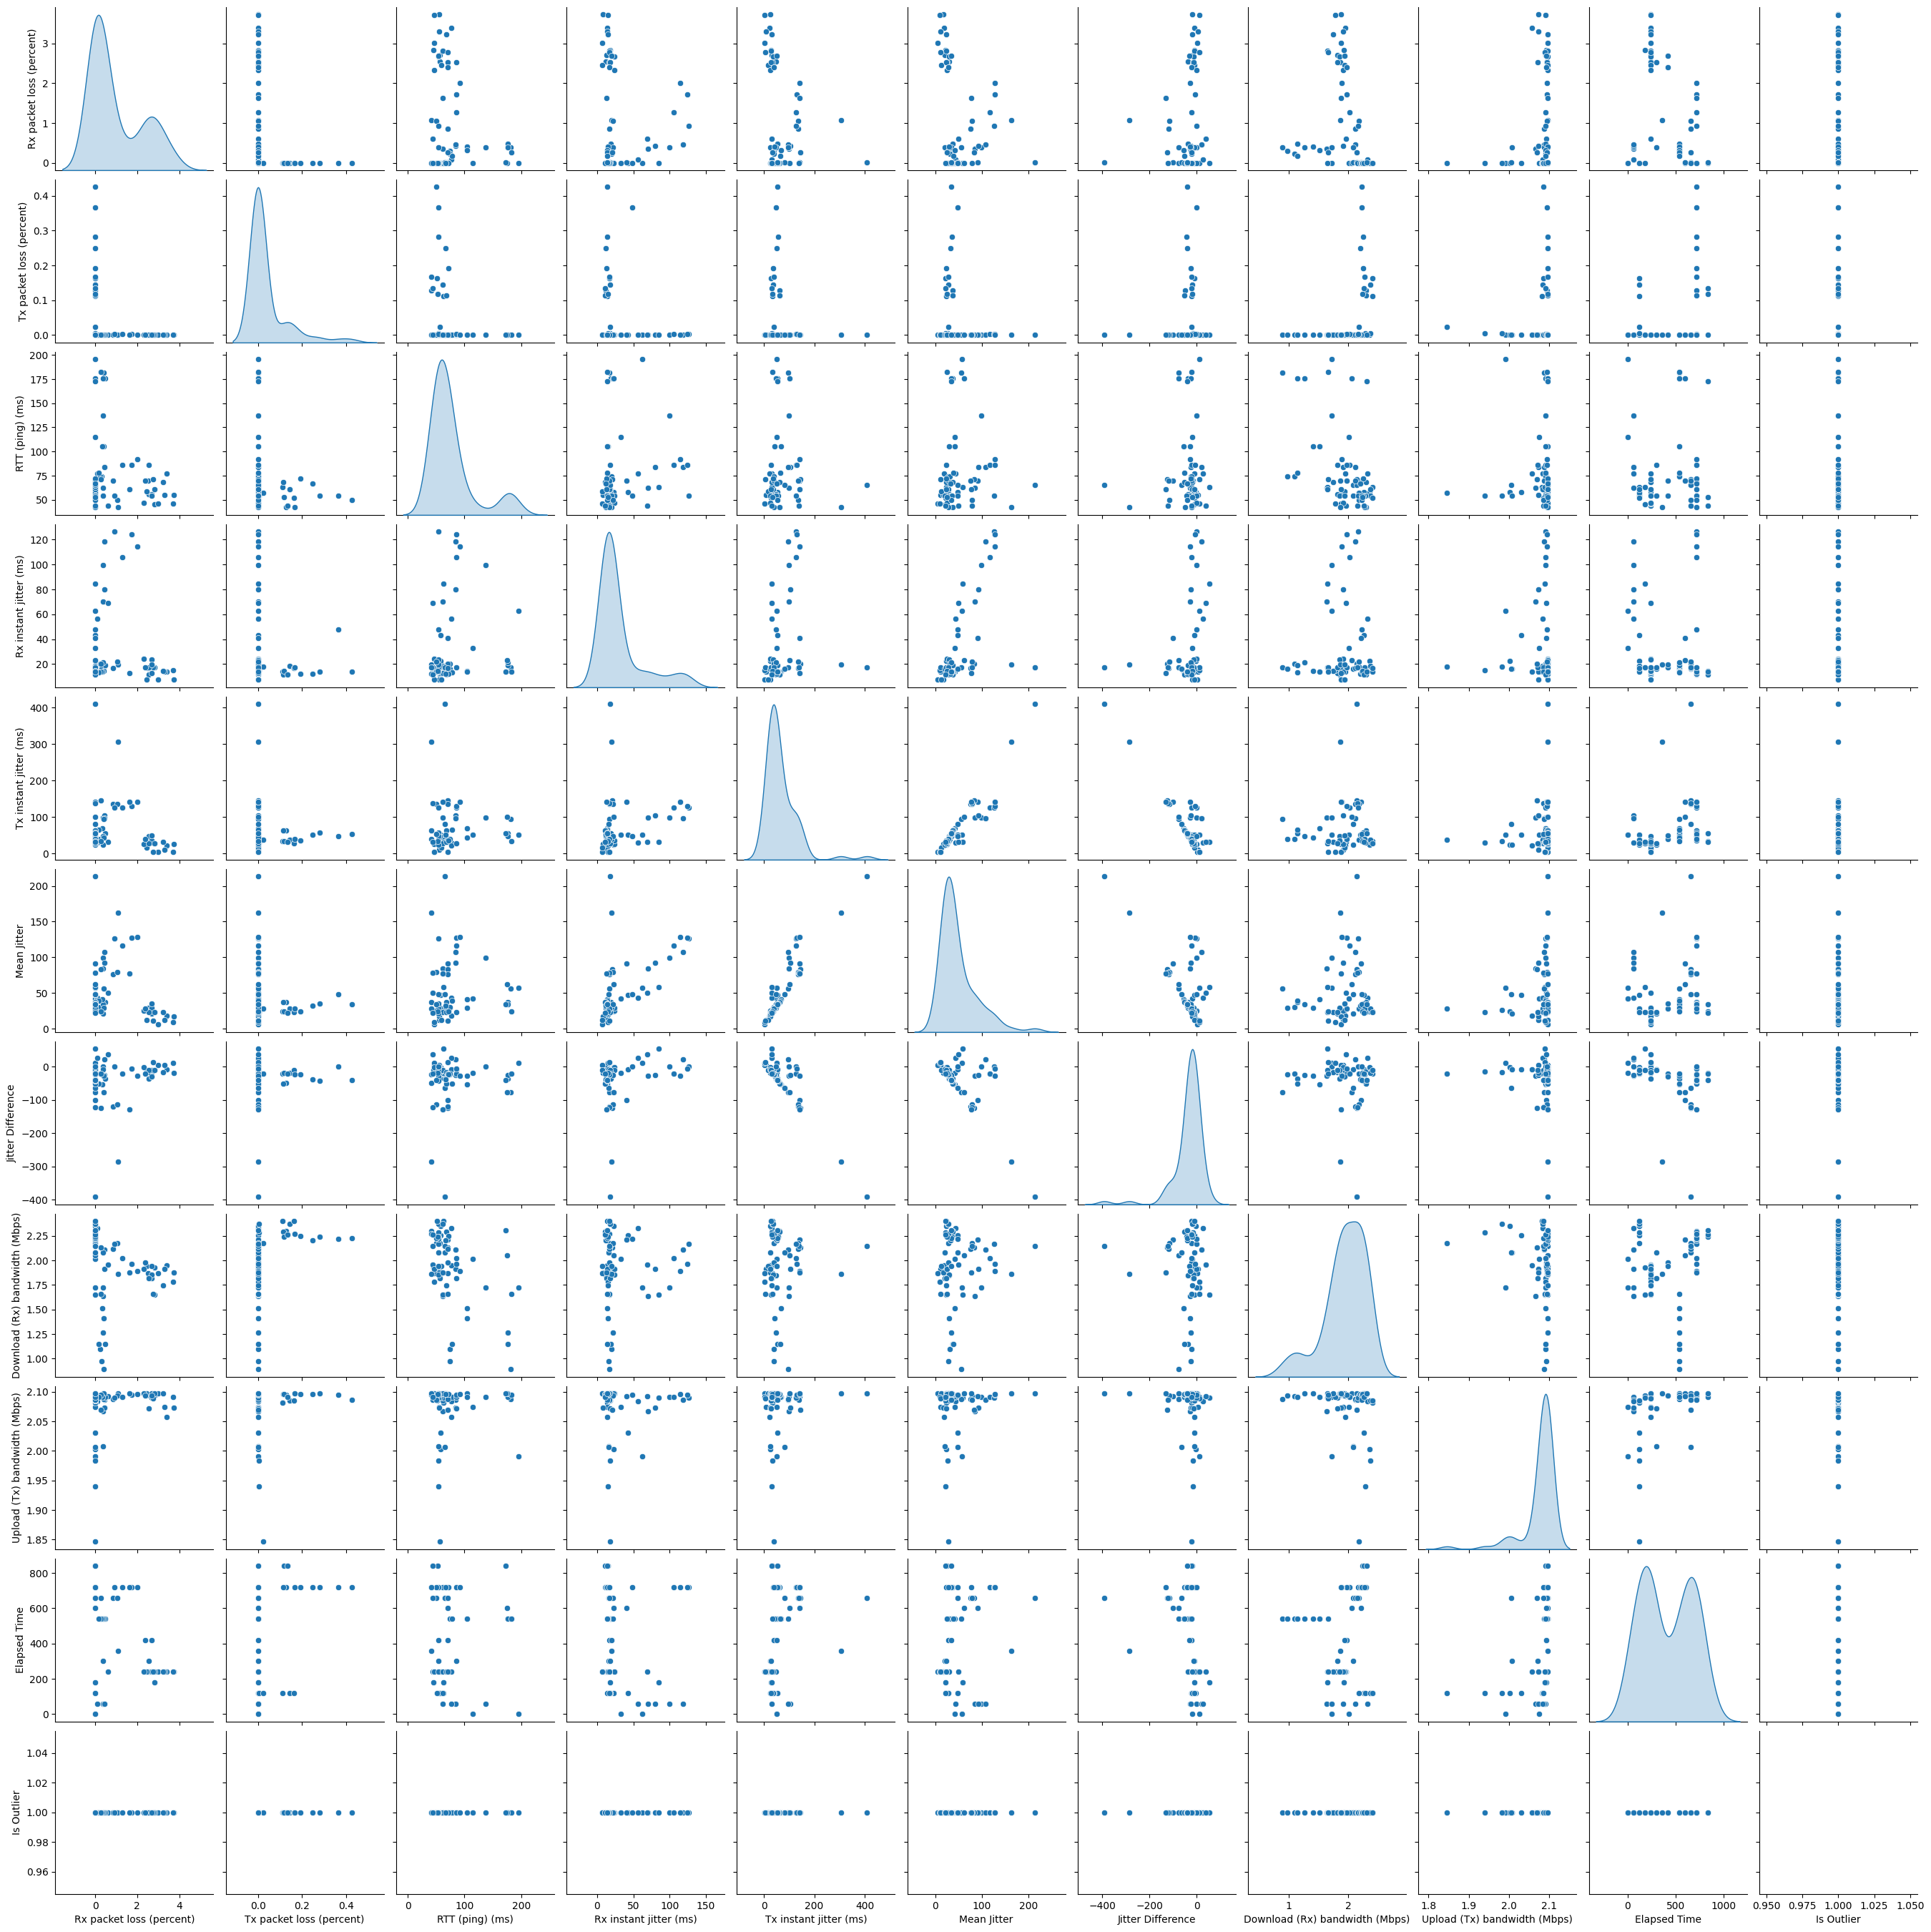

In [12]:
from scipy.stats import zscore
import numpy as np

# Calculate z-scores for numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
z_scores = np.abs(data[numeric_columns].apply(zscore))

# Define a threshold for outliers
threshold = 3

# Flag outliers
data['Is Outlier'] = (z_scores > threshold).any(axis=1)

# Display the number of flagged outliers
num_outliers = data['Is Outlier'].sum()
print(f"Number of Outliers Preserved: {num_outliers}")

# Separate outliers for analysis
outliers = data[data['Is Outlier']]
non_outliers = data[~data['Is Outlier']]

# Summary statistics for outliers vs non-outliers
print("\nSummary of Outliers:")
display(outliers.describe())
print("\nSummary of Non-Outliers:")
display(non_outliers.describe())


# Pairplot for outliers to explore relationships
import seaborn as sns
figplot = sns.pairplot(outliers, diag_kind="kde", markers="o")



### Findings from the Pair Plot:

### * Diagonal Plots (Distributions):Variables like Download Bandwidth showed moderate spread, while jitter and packet loss exhibited higher variability.
### * Scatter Plots: Weak correlations between some variables (e.g., Rx and Tx jitter) suggest that extreme conditions affect QoS metrics independently.
### * Clustering in certain plots indicates distinct types of network degradation.

### **Outliers represent important edge cases (e.g., poor bandwidth, high jitter) that must be retained for analyzing extreme rural conditions.**

## Saving the current prepared data

In [13]:
print("\nDataset after anaylsis & preparation:")
display(data.head(100))

# After handling missing and invalid data
data['Service'] = 'Zoom'


# Save the cleaned and preprocessed data for downstream tasks
output_path = './zoom480p_preprocessed.csv'
data.to_csv(output_path, index=False)

print("\nPreprocessed dataset saved as 'zoom480p_preprocessed.csv'.")



Dataset after anaylsis & preparation:


,Local time,Rx packet loss (percent),Tx packet loss (percent),RTT (ping) (ms),Rx instant jitter (ms),Tx instant jitter (ms),Mean Jitter,Jitter Difference,Download (Rx) bandwidth (Mbps),Upload (Tx) bandwidth (Mbps),Elapsed Time,Is Outlier
728,2023-11-22 17:15:00,0.000000e+00,0.0,59.00000,18.075400,33.649998,25.862699,-15.574598,1.597503,2.073520,0.0,False
706,2023-11-22 17:15:00,5.774397e-02,0.0,42.00000,14.900800,25.573900,20.237350,-10.673100,1.785374,2.071365,0.0,False
707,2023-11-22 17:15:00,0.000000e+00,0.0,42.00000,15.165999,59.054398,37.110198,-43.888399,1.782008,2.097152,0.0,False
708,2023-11-22 17:15:00,0.000000e+00,0.0,195.62039,62.715897,51.525997,57.120947,11.189900,1.726811,1.990756,0.0,True
709,2023-11-22 17:15:00,0.000000e+00,0.0,115.00000,32.779000,51.525997,42.152499,-18.746997,2.013898,2.074388,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
601,2023-11-22 17:17:00,8.230000e-08,0.0,63.00000,14.017699,26.984499,20.501099,-12.966800,2.383072,2.092579,120.0,False
594,2023-11-22 17:17:00,0.000000e+00,0.0,46.00000,13.104400,23.762700,18.433550,-10.658300,2.456453,2.094249,120.0,False
599,2023-11-22 17:17:00,1.372995e+00,0.0,53.00000,22.653000,32.599300,27.626150,-9.946300,2.266962,2.097152,120.0,False
598,2023-11-22 17:17:00,1.107951e+00,0.0,63.00000,11.134399,22.435299,16.784849,-11.300900,2.337873,2.094947,120.0,False



Preprocessed dataset saved as 'zoom480p_preprocessed.csv'.


# 📺 | Services Comparison (Google Meet , Microsoft Teams, Zoom)

## Loading & Inspecting Pre-processed Datasets

In [14]:
# Load preprocessed datasets
gmeet_data = pd.read_csv('/kaggle/input/pre-processed-datasets/gmeet480p_preprocessed.csv')
teams_data = pd.read_csv('/kaggle/input/pre-processed-datasets/teams480p_preprocessed.csv')
zoom_data = pd.read_csv('/kaggle/input/pre-processed-datasets/zoom480p_preprocessed.csv')

# Display dataset info
print("Gmeet Dataset Info:")
print(gmeet_data.info(), "\n")
print("Teams Dataset Info:")
print(teams_data.info(), "\n")
print("Zoom Dataset Info:")
print(zoom_data.info(), "\n")


Gmeet Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Local time                      667 non-null    object 
 1   Rx packet loss (percent)        667 non-null    float64
 2   Tx packet loss (percent)        667 non-null    float64
 3   RTT (ping) (ms)                 667 non-null    float64
 4   Rx instant jitter (ms)          667 non-null    float64
 5   Tx instant jitter (ms)          667 non-null    float64
 6   Mean Jitter                     667 non-null    float64
 7   Jitter Difference               667 non-null    float64
 8   Download (Rx) bandwidth (Mbps)  667 non-null    float64
 9   Upload (Tx) bandwidth (Mbps)    667 non-null    float64
 10  Elapsed Time                    667 non-null    float64
 11  Is Outlier                      667 non-null    bool   
 12  Service         

## Comparing & Visualizing Key QoS Metrics

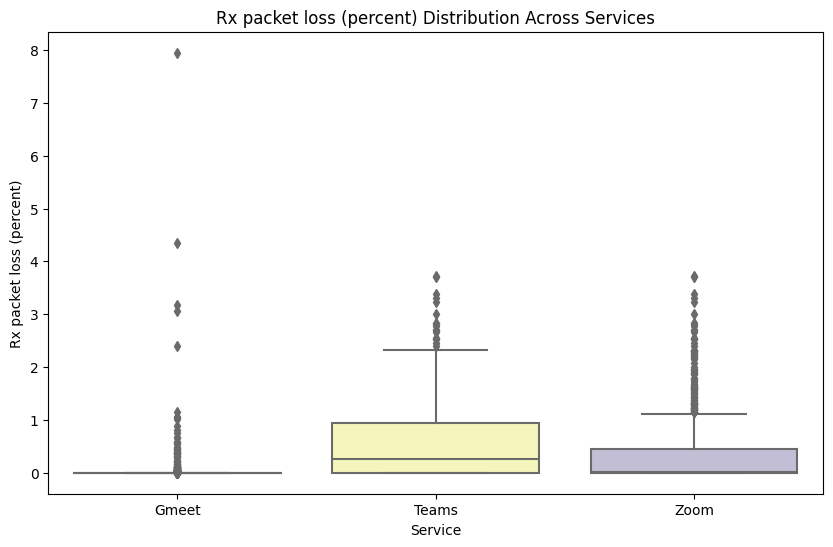

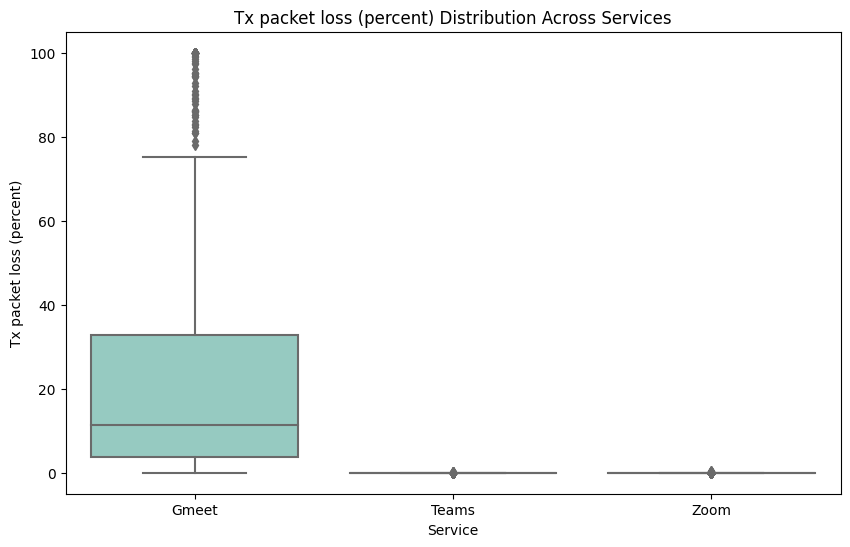

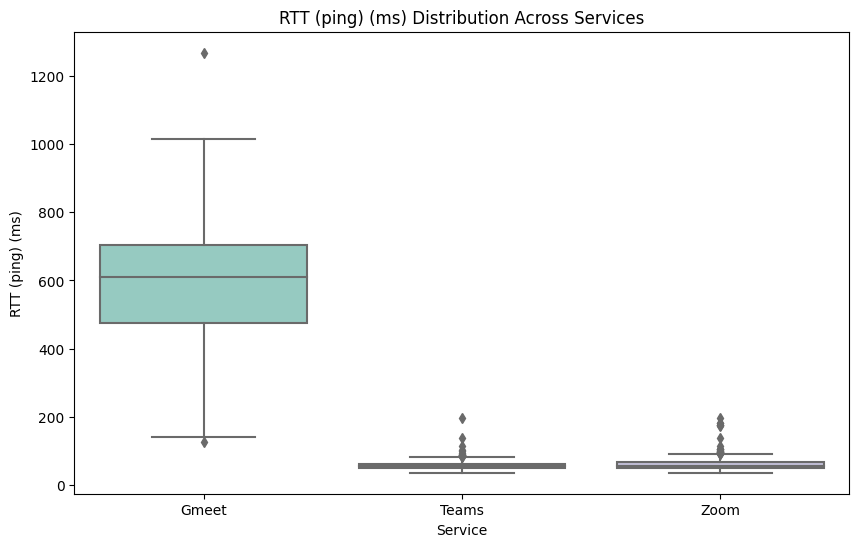

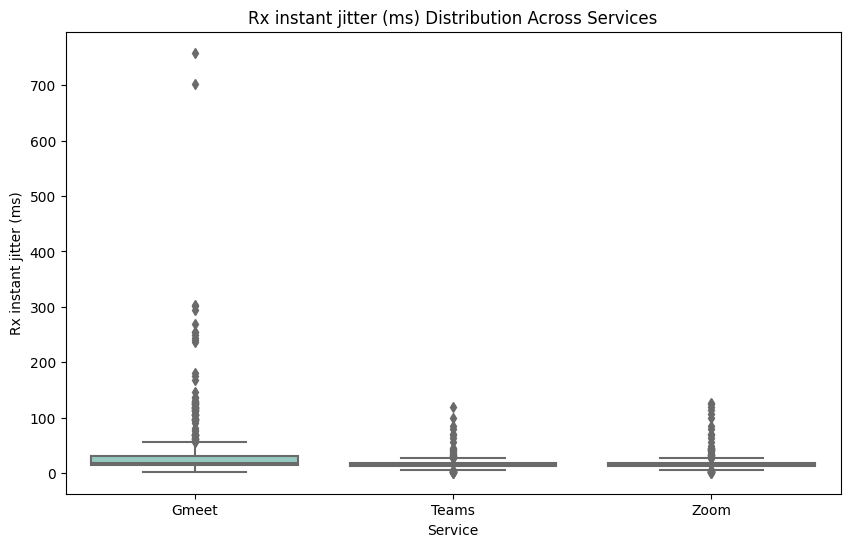

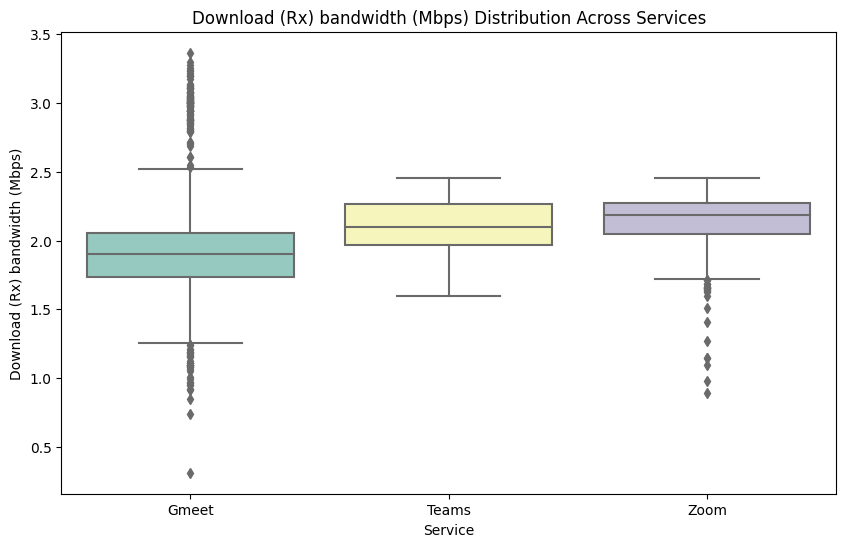

In [15]:
metrics = ['Rx packet loss (percent)', 'Tx packet loss (percent)', 
           'RTT (ping) (ms)', 'Rx instant jitter (ms)', 
           'Download (Rx) bandwidth (Mbps)']

# Visualize each metric for all services
datasets = {'Gmeet': gmeet_data, 'Teams': teams_data, 'Zoom': zoom_data}
for metric in metrics:
    plt.figure(figsize=(10, 6))
    # Combine datasets for the current metric with a 'Service' column
    combined_data = pd.concat([
        data[[metric]].assign(Service=service) for service, data in datasets.items()
    ], ignore_index=True)
    # Create boxplot
    sns.boxplot(data=combined_data, x='Service', y=metric, palette='Set3')
    plt.title(f'{metric} Distribution Across Services')
    plt.ylabel(metric)
    plt.xlabel('Service')
    plt.show()


## Assessing Variability and Stability

In [16]:
# Compute standard deviation for QoS metrics
for service, data in datasets.items():
    print(f"Standard Deviation for {service}:")
    display(data[metrics].std())


Standard Deviation for Gmeet:


Rx packet loss (percent)            0.418089
Tx packet loss (percent)           32.228649
RTT (ping) (ms)                   155.069073
Rx instant jitter (ms)             55.286660
Download (Rx) bandwidth (Mbps)      0.486048
dtype: float64

Standard Deviation for Teams:


Rx packet loss (percent)           0.778546
Tx packet loss (percent)           0.014196
RTT (ping) (ms)                   13.858812
Rx instant jitter (ms)            11.091293
Download (Rx) bandwidth (Mbps)     0.198252
dtype: float64

Standard Deviation for Zoom:


Rx packet loss (percent)           0.654023
Tx packet loss (percent)           0.030842
RTT (ping) (ms)                   17.524060
Rx instant jitter (ms)            11.635208
Download (Rx) bandwidth (Mbps)     0.197629
dtype: float64

In [17]:
# Identify outliers for each metric using 1.5 * IQR rule
for service, data in datasets.items():
    print(f"Outliers for {service}:")
    for metric in metrics:
        q1 = data[metric].quantile(0.25)
        q3 = data[metric].quantile(0.75)
        iqr = q3 - q1
        outliers = data[(data[metric] < (q1 - 1.5 * iqr)) | (data[metric] > (q3 + 1.5 * iqr))]
        print(f"{metric}: {len(outliers)} outliers")


Outliers for Gmeet:
Rx packet loss (percent): 156 outliers
Tx packet loss (percent): 98 outliers
RTT (ping) (ms): 2 outliers
Rx instant jitter (ms): 79 outliers
Download (Rx) bandwidth (Mbps): 130 outliers
Outliers for Teams:
Rx packet loss (percent): 17 outliers
Tx packet loss (percent): 96 outliers
RTT (ping) (ms): 18 outliers
Rx instant jitter (ms): 36 outliers
Download (Rx) bandwidth (Mbps): 0 outliers
Outliers for Zoom:
Rx packet loss (percent): 87 outliers
Tx packet loss (percent): 173 outliers
RTT (ping) (ms): 26 outliers
Rx instant jitter (ms): 50 outliers
Download (Rx) bandwidth (Mbps): 22 outliers


## Aggregating Performance Scores of Services (Gmeet, Teams, Zoom)

Average Scores by Service:
Gmeet: 0.7819775103737302
Teams: 0.8472209773181778
Zoom: 0.8429250308771691


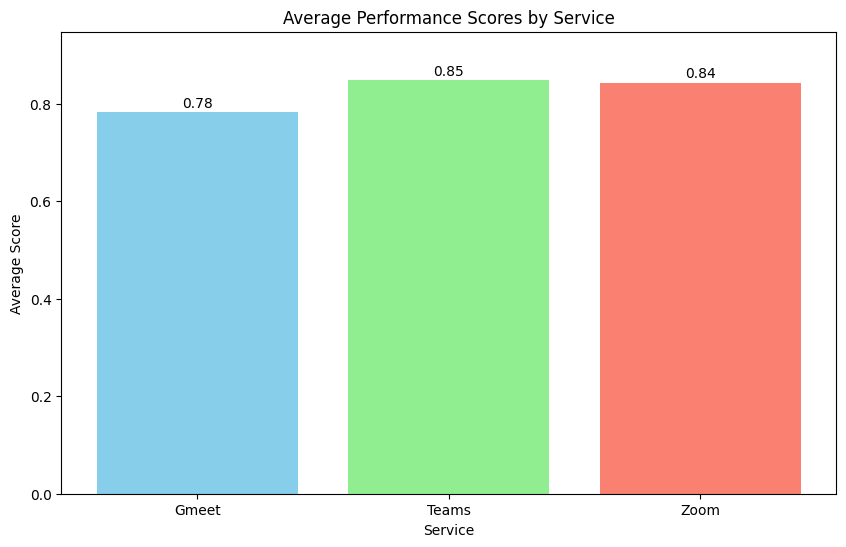

In [18]:
metrics = ['Rx packet loss (percent)', 'Tx packet loss (percent)', 
           'RTT (ping) (ms)', 'Rx instant jitter (ms)', 
           'Download (Rx) bandwidth (Mbps)']

weights = {
    'Rx packet loss (percent)': 0.3,
    'Tx packet loss (percent)': 0.3,
    'RTT (ping) (ms)': 0.2,
    'Rx instant jitter (ms)': 0.1,
    'Download (Rx) bandwidth (Mbps)': 0.1
}

# Function to calculate scores
def calculate_scores(data, metrics, weights):
    # Normalize metrics
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(data[metrics])
    
    # Invert normalized values to ensure lower QoS values (better performance) get higher scores
    inverted = 1 - normalized
    
    # Compute weighted score
    scores = inverted @ pd.Series(weights).values  # Matrix multiplication for scores
    return scores

# Calculate scores for each dataset
gmeet_scores = calculate_scores(gmeet_data, metrics, weights)
teams_scores = calculate_scores(teams_data, metrics, weights)
zoom_scores = calculate_scores(zoom_data, metrics, weights)

# Add scores back to the datasets for analysis
gmeet_data['Score'] = gmeet_scores
teams_data['Score'] = teams_scores
zoom_data['Score'] = zoom_scores

# Calculate average scores for each service
average_scores = {
    'Gmeet': gmeet_data['Score'].mean(),
    'Teams': teams_data['Score'].mean(),
    'Zoom': zoom_data['Score'].mean()
}

print("Average Scores by Service:")
for service, score in average_scores.items():
    print(f"{service}: {score}")

# Plot average scores for each service
plt.figure(figsize=(10, 6))
plt.bar(average_scores.keys(), average_scores.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Performance Scores by Service')
plt.ylabel('Average Score')
plt.xlabel('Service')
plt.ylim(0, max(average_scores.values()) + 0.1)  # Set y-limit slightly above the max score for better visualization
for i, score in enumerate(average_scores.values()):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center', fontsize=10)  # Add score labels on the bars
plt.show()


## Evaluate Dataset Suitability

### Dataset Diversity

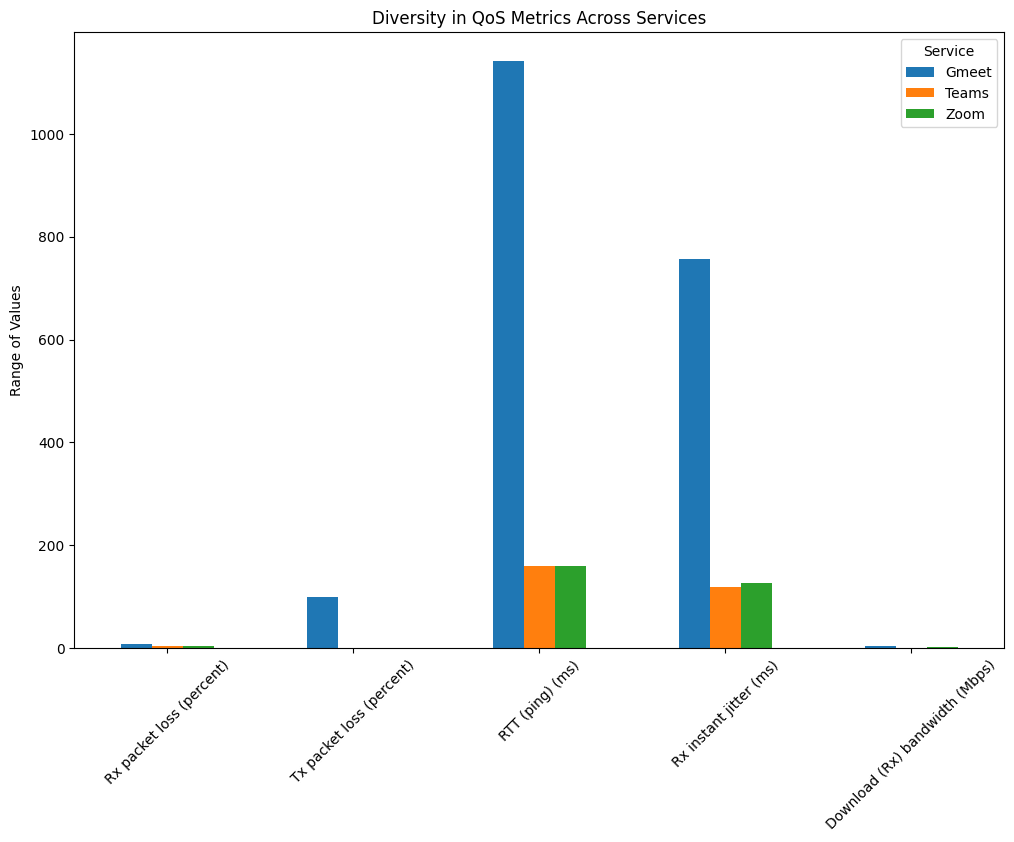

In [19]:
# Calculate diversity in QoS metrics for each service using range
diversity_data = {}
for service, data in datasets.items():
    diversity = data[metrics].max() - data[metrics].min()
    diversity_data[service] = diversity

# Convert to DataFrame for visualization
diversity_df = pd.DataFrame(diversity_data)

# Plot diversity for each metric
diversity_df.plot(kind='bar', figsize=(12, 8), title='Diversity in QoS Metrics Across Services')
plt.ylabel('Range of Values')
plt.xticks(rotation=45)
plt.legend(title="Service", loc='upper right')
plt.show()


### Dataset Size

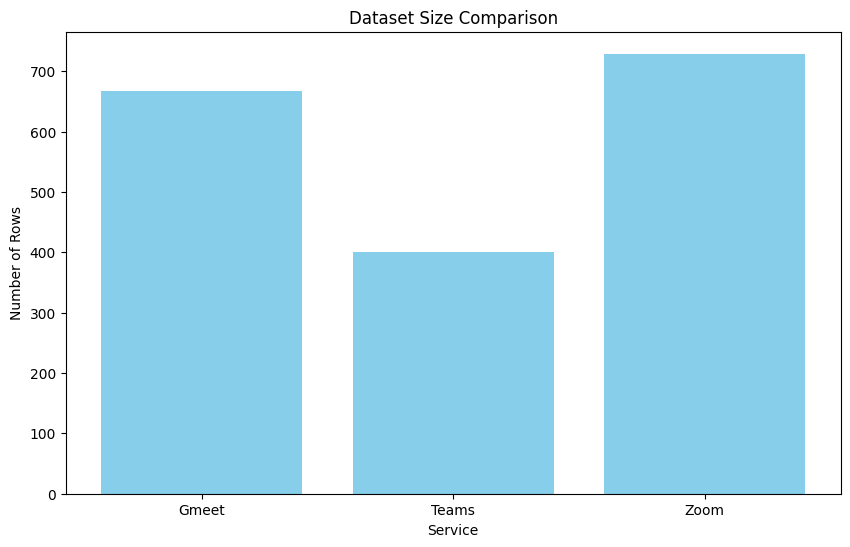

In [20]:
# Calculate dataset size for each service
dataset_sizes = {service: len(data) for service, data in datasets.items()}

# Plot dataset sizes
plt.figure(figsize=(10, 6))
plt.bar(dataset_sizes.keys(), dataset_sizes.values(), color='skyblue')
plt.title('Dataset Size Comparison')
plt.ylabel('Number of Rows')
plt.xlabel('Service')
plt.show()


### Distribution of Challenging/Poor QoS Conditons

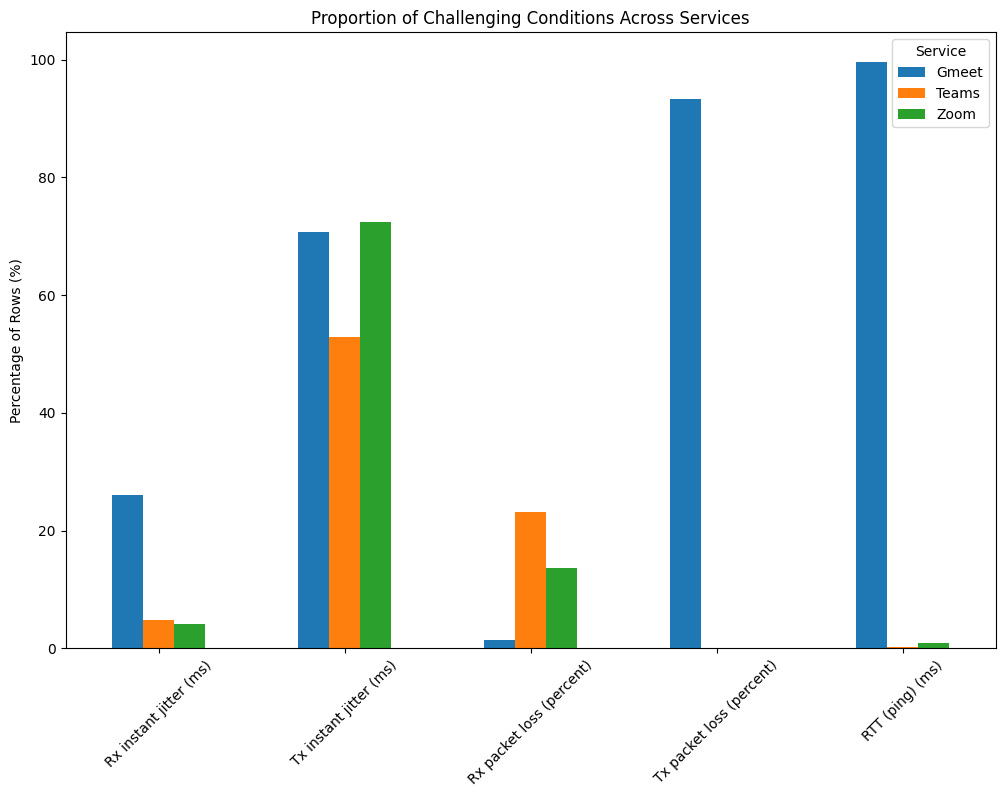

In [21]:
# Define thresholds for challenging conditions
thresholds = {
    'Rx instant jitter (ms)': 30,
    'Tx instant jitter (ms)': 30,
    'Rx packet loss (percent)': 1,
    'Tx packet loss (percent)': 1,
    'RTT (ping) (ms)': 150
}

# Calculate proportion of challenging conditions
challenging_data = {}
for service, data in datasets.items():
    proportions = {}
    for metric, threshold in thresholds.items():
        challenging_rows = len(data[data[metric] > threshold])
        proportions[metric] = challenging_rows / len(data) * 100  # Percentage
    challenging_data[service] = proportions

# Convert to DataFrame for visualization
challenging_df = pd.DataFrame(challenging_data)

# Plot challenging conditions for each metric
challenging_df.plot(kind='bar', figsize=(12, 8), title='Proportion of Challenging Conditions Across Services')
plt.ylabel('Percentage of Rows (%)')
plt.xticks(rotation=45)
plt.legend(title="Service", loc='upper right')
plt.show()


## Visualizing Dataset Suitability

Dataset Suitability Rankings (Weighted - Z-Score):


,Diversity,Size,Challenging Conditions,Final Score
Gmeet,1.414199,0.477942,1.412911,1.039568
Zoom,-0.701604,0.913712,-0.653911,-0.050708
Teams,-0.712595,-1.391654,-0.759001,-0.988859


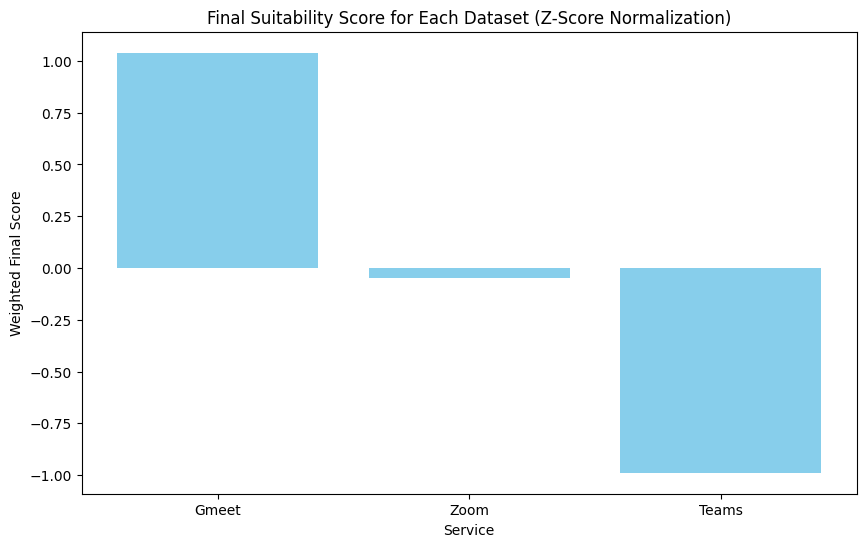

In [22]:
# Define the components of suitability
suitability_ranking = {
    'Diversity': diversity_df.mean(axis=0),  # Average diversity across all metrics
    'Size': pd.Series(dataset_sizes),       # Dataset size
    'Challenging Conditions': challenging_df.mean(axis=0)  # Average % of challenging conditions
}

# Combine into a DataFrame
suitability_df = pd.DataFrame(suitability_ranking)

# Ensure no missing values
suitability_df = suitability_df.fillna(0)

# Apply Z-Score Normalization
scaler = StandardScaler()
zscore_normalized_suitability = scaler.fit_transform(suitability_df)
suitability_df_normalized = pd.DataFrame(zscore_normalized_suitability, columns=suitability_df.columns, index=suitability_df.index)

# Define weights for each criterion
criteria_weights = {
    'Diversity': 0.5,
    'Size': 0.4,
    'Challenging Conditions': 0.1
}

# Calculate weighted final scores
suitability_df_normalized['Final Score'] = (
    suitability_df_normalized['Diversity'] * criteria_weights['Diversity'] +
    suitability_df_normalized['Size'] * criteria_weights['Size'] +
    suitability_df_normalized['Challenging Conditions'] * criteria_weights['Challenging Conditions']
)

# Sort by final score to determine the best dataset
suitability_df_normalized = suitability_df_normalized.sort_values('Final Score', ascending=False)

# Display rankings
print("Dataset Suitability Rankings (Weighted - Z-Score):")
display(suitability_df_normalized)

# Plot final scores
plt.figure(figsize=(10, 6))
plt.bar(suitability_df_normalized.index, suitability_df_normalized['Final Score'], color='skyblue')
plt.title('Final Suitability Score for Each Dataset (Z-Score Normalization)')
plt.ylabel('Weighted Final Score')
plt.xlabel('Service')
plt.show()
